## Импортируем библиотеки

In [2]:
import pandas as pd 
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/mw/hbn8df4d2jg5fxmmbxrx1rj80000gn/T/ipykernel_24563/2974861192.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
dtypes = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

Считываем необходимые файлы для дальшейней обработки плюс первичный анализ содержимого

In [4]:
# Главный Датасет
train = pd.read_csv('/Users/seegment/Desktop/Магистратура/Программирование на Python/Домашнее задание 3/train.csv', dtype=dtypes)
del dtypes
train.pop('row_id')
#вспомогательные df 
lectures = pd.read_csv('/Users/seegment/Desktop/Магистратура/Программирование на Python/Домашнее задание 3/lectures.csv')
questions = pd.read_csv('/Users/seegment/Desktop/Магистратура/Программирование на Python/Домашнее задание 3/questions.csv')

In [5]:
# Собираем первичную информацию о DF
train.info()
lectures.info()
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 2.4 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    i

In [6]:
# Делаем предварительный анализ всех таблиц (в разных блоках чтобы сохранить внешний вид таблиц)
train.head()

#row_id - Индекс строки
#timestamp - затраченное время
#user_id - Иденткфикатор пользователя 
#content_id - Код идентефикатора взаимодействия пользователя ???
#content_type_id - 0 в случае если вопрос; 1 в случае если лекция
#task_container_id - что-то вроде объединения для теста. То есть несколько вопросов могут быть в рамках одного данного id 
#user_answer - ответ пользователя (-1 в случае лекции)
#answered_correctly - правильный ответ на вопрос (-1 в случае лекции)
#prior_question_elapsed_time - 
#prior_question_had_explanation - увидел ли пользователь ответ пна предыдущий контейнер вопросов 



,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
lectures.head()

# lecture_id - внешний ключ для DF - связывается с content_id (для тип content_type_id = 1) 
# tag - ?
# part - кластеризация
# type_of - краткое описание цели лекции

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [8]:
questions.head()

# question_id - внешний ключ для DF - связывается с content_id (для тип content_type_id = 0)
# bundle_id - код, 
# correct_answer - правильный ответ (но уже в цифре)
# part соответствующий раздел теста 
# tags - кластеризация вопросов 

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Задача: Проанализировать как можно больше характеристик, влияющих на успеваемость студентов. 

Успеваемость - это процент, корректно выполненых студентом вопросов на протяжении всего учебного периода

In [9]:
# Для начала я хочу разделить лекции и вопросы, чтобы в дальнейшем анализировать с использованием дополнительных словарей 
train_questions = train[train['content_type_id'] == 0].merge(questions, left_on='content_id', right_on='question_id', how='left')
train_lectures = train[train['content_type_id'] == 1].merge(lectures, left_on='content_id', right_on='lecture_id', how='left')

In [10]:
# Также я создам признак, по которому сделаем дополнительную проверку на соответсвие справочника по правильным ответам с данными из исходной таблицы
train_questions['is_correct'] = (train_questions['user_answer'] == train_questions['correct_answer']).astype(int)
print('Количество различий: ',train_questions[train_questions['is_correct'] != train_questions['answered_correctly']].value_counts().to_string())
# Так как различий нет - убираем один из атрибутов
train_questions.pop('answered_correctly')
train_questions.pop('user_answer')
train_questions.pop('correct_answer')

Количество различий:  Series([], )


0           3
1           2
2           0
3           0
4           1
           ..
99271295    0
99271296    3
99271297    3
99271298    0
99271299    3
Name: correct_answer, Length: 99271300, dtype: int64

1 Гипотеза:

Просмотр ответов на предыдущий блок вопросов помогает соорентироваться в текущем

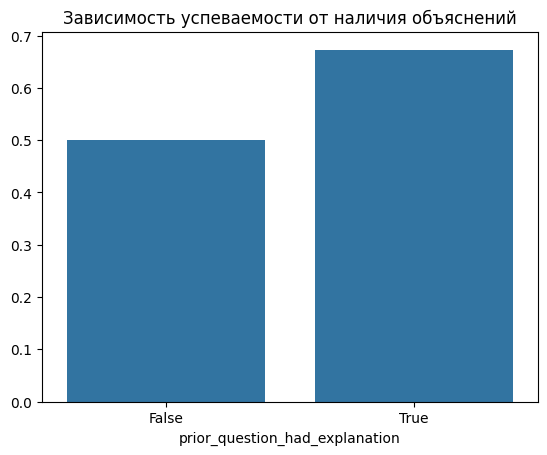

In [11]:
# Анализ использования объяснений
explanation_stats = train_questions.copy()
# Как мы поняли, в 0 task_container_id в стобце prior_question_had_explanation проставляются пустые ячейки, поэтому уберем их для анализа
explanation_stats = explanation_stats.dropna(subset=['prior_question_had_explanation'])

# Делаем группировку по среднему от правильнвых ответов
explanation_stats = train_questions.groupby('prior_question_had_explanation')['is_correct'].mean()


# Визуализируем
sns.barplot(x=explanation_stats.index, y=explanation_stats.values)
plt.title("Зависимость успеваемости от наличия объяснений")
plt.show()

2 Гипотеза:

Правильность ответов зависит от просмотра лекций

In [12]:
# У лекций есть типы, но я не смог перевести  значение, поэтому будем считать, что они в равной степени влияют на успешность в прохождении теста 
train_lectures['type_of'].unique()

array(['intention', 'concept', 'solving question', 'starter'],
      dtype=object)

In [76]:
# Для начала создадим переменнцую, в которой запишем id человека и факт просмотренной определенной лекции 
#train_lectures_id = train_lectures.groupby('user_id')['task_container_id'].value_counts()
#train_lectures_id = train_lectures.groupby('user_id')['content_type_id'].value_counts()

In [43]:
# Подсчитаем количество лекций, просмотренных студентом
user_lecture_counts = train_lectures.groupby('user_id')['content_id'].count().reset_index()
user_lecture_counts.columns = ['user_id', 'lecture_count']

In [ ]:
# Подсчитаем успеваемость студента 
# Группируем данные по user_id и считаем общее количество ответов и количество правильных ответов
user_correct_answers = train_questions.groupby('user_id')['is_correct'].agg(['count', 'sum']).reset_index()

# Переименовываем столбцы для ясности
user_correct_answers.columns = ['user_id', 'total_answers', 'correct_answers']

# Рассчитываем процент правильных ответов для каждого студента
user_correct_answers['correct_answer_percentage'] = (user_correct_answers['correct_answers'] / user_correct_answers['total_answers']) * 100

# Оставим только столбцы user_id и процент правильных ответов
user_correct_answers = user_correct_answers[['user_id', 'correct_answer_percentage']]

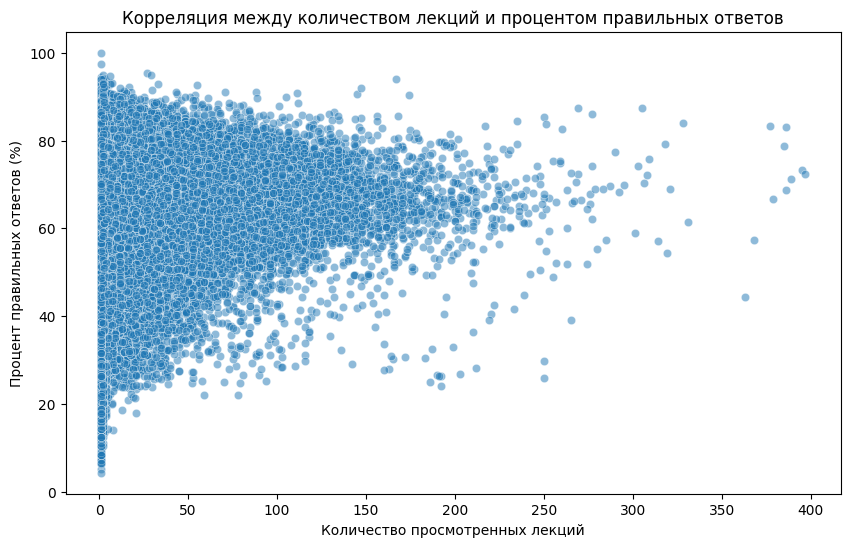

Коэффициент корреляции между количеством лекций и процентом правильных ответов: 0.17


In [47]:
# Объединяем две таблицы по user_id
merged_data = pd.merge(user_lecture_counts, user_correct_answers, on='user_id', how='inner')

# Визуализация корреляции: количество лекций vs процент правильных ответов
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_data, x='lecture_count', y='correct_answer_percentage', alpha=0.5)
plt.title('Корреляция между количеством лекций и процентом правильных ответов')
plt.xlabel('Количество просмотренных лекций')
plt.ylabel('Процент правильных ответов (%)')
plt.show()

# Вычисляем коэффициент корреляции Пирсона между количеством лекций и процентом правильных ответов
correlation = merged_data['lecture_count'].corr(merged_data['correct_answer_percentage'])
print(f'Коэффициент корреляции между количеством лекций и процентом правильных ответов: {correlation:.2f}')
